# Train 3D CAE  

Notebook Author: Aniket Tekawade, Argonne National Laboratory, atekawade@anl.gov  

In [1]:
%matplotlib inline

import sys
import os
import numpy as np
import pandas as pd
import h5py
import time

import matplotlib.pyplot as plt
import matplotlib as mpl

from tomo_encoders.img_stats import Parallelize, calc_jac_acc, pore_analysis
from tomo_encoders.data_sampling import *
from tomo_encoders.porosity_encoders import custom_objects_dict, build_CAE_3D
from tomo_encoders.latent_vis import *

from tensorflow.keras.models import load_model
import pickle

figw = 8
import seaborn as sns
sns.set(font_scale = 1)
sns.set_style("whitegrid", {'axes.grid' : False})

In [3]:
batch_size = 24
patch_size = (64,64,64)
n_epochs = 30
downres = 2
data_path = "/data02/MyArchive/aisteer_3Dencoders/data_TomoTwin/"
model_path = "/data02/MyArchive/aisteer_3Dencoders/models/"

In [4]:
other_tag = "set6"
vol_shape = (patch_size) + (1,)
n_filters = [32, 64, 128]
n_blocks = 3
activation = 'lrelu'
batch_norm = True
hidden_units = [128, 32]
isconcat = [True, True, False]
pool_size = [2,2,2]
stdinput = True
add_noise = 0.18
random_rotate = True

In [5]:
model_tag = "%i%i%id%s_%s"%(isconcat[0], \
                            isconcat[1], \
                            isconcat[2], \
                            hidden_units[-1], \
                            other_tag)
model_names = {"segmenter" : "segmenter%s.hdf5"%model_tag, \
               "encoder" : "encoder%s.hdf5"%model_tag, \
               "PCA" : "PCA%s.pkl"%model_tag}
model_names

{'segmenter': 'segmenter110d32_set6.hdf5',
 'encoder': 'encoder110d32_set6.hdf5',
 'PCA': 'PCA110d32_set6.pkl'}

## Test the Data Generator  

In [6]:
csv_path = os.path.join(data_path, "datalist_train.csv")

In [7]:
Xs, Ys, plot_labels = get_data_from_flist(csv_path, \
                                          normalize = True, \
                                          data_tags = ("recon", "gt_labels"),\
                                          group_tags = ["tomo"], \
                                          downres = downres)

dg = utils.data_generator_4D(Xs, Ys, patch_size, \
                             batch_size, \
                             add_noise = add_noise, \
                             random_rotate = random_rotate)
x, y = next(dg)
print("Shape of x: %s"%str(x.shape))

Shape of x: (24, 64, 64, 64, 1)


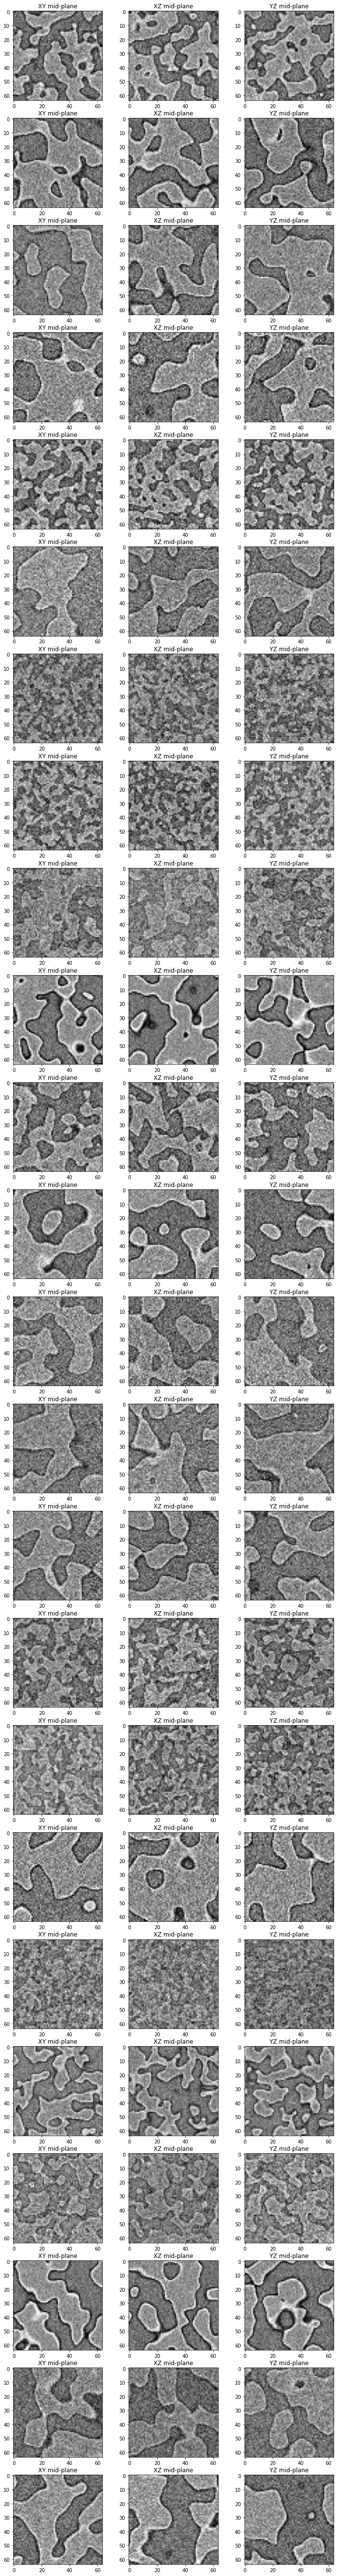

In [8]:
fig, ax = plt.subplots(batch_size,3, figsize = (figw,batch_size*figw/3))
for ib in range(batch_size):
    viewer.view_midplanes(vol = x[ib,:,:,:,0], ax = ax[ib])

## Build and train the 3D VAE Model  
The 3D U-net model is defined in models3D.py
We will use model.fit() to train and pass the generator object

In [10]:
encoder, segmenter = build_CAE_3D(vol_shape, \
                                  n_filters = n_filters,\
                                  n_blocks = n_blocks,\
                                  activation = activation,\
                                  batch_norm = batch_norm,\
                                  hidden_units = hidden_units,\
                                  isconcat = isconcat, \
                                  pool_size = pool_size, \
                                  stdinput = stdinput)
import tensorflow as tf
segmenter.compile(optimizer=tf.keras.optimizers.Adam(),\
              loss=tf.keras.losses.BinaryCrossentropy())
encoder.compile()

In [11]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 64, 1)]   0         
_________________________________________________________________
lambda (Lambda)              (None, 64, 64, 64, 1)     0         
_________________________________________________________________
conv3d (Conv3D)              (None, 64, 64, 64, 32)    896       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64, 32)    128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 64, 64, 64, 64)    55360     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64, 64)    256 

In [12]:
from tensorflow.keras.utils import plot_model

In [13]:
plot_model(segmenter, show_shapes = True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [14]:
segmenter.summary()

Model: "segmenter"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 64,  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 64, 64, 64, 1 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 64, 64, 64, 3 896         lambda[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 64, 3 128         conv3d[0][0]                     
__________________________________________________________________________________________

In [15]:
tot_steps = 500
val_split = 0.2
steps_per_epoch = int((1-val_split)*tot_steps//batch_size)
validation_steps = int(val_split*tot_steps//batch_size)

segmenter.fit(x = dg, epochs = n_epochs,\
          steps_per_epoch=steps_per_epoch,\
          validation_steps=validation_steps, verbose = 1)    

Epoch 1/30
16/16 [==============================] - 79s 2s/step - loss: 0.3073
Epoch 2/30
16/16 [==============================] - 38s 2s/step - loss: 0.1160
Epoch 3/30
16/16 [==============================] - 38s 2s/step - loss: 0.1126
Epoch 4/30
16/16 [==============================] - 38s 2s/step - loss: 0.0942
Epoch 5/30
16/16 [==============================] - 38s 2s/step - loss: 0.0897
Epoch 6/30
16/16 [==============================] - 38s 2s/step - loss: 0.0861
Epoch 7/30
16/16 [==============================] - 38s 2s/step - loss: 0.0921
Epoch 8/30
16/16 [==============================] - 38s 2s/step - loss: 0.0852
Epoch 9/30
16/16 [==============================] - 38s 2s/step - loss: 0.0878
Epoch 10/30
16/16 [==============================] - 38s 2s/step - loss: 0.0794
Epoch 11/30
16/16 [==============================] - 38s 2s/step - loss: 0.0741
Epoch 12/30
16/16 [==============================] - 38s 2s/step - loss: 0.0758
Epoch 13/30
16/16 [==============================

### Do PCA  

In [16]:
n_samples = 5000

In [17]:
dg = utils.data_generator_4D(Xs, Ys, \
                             patch_size, n_samples, \
                             scan_idx = True, add_noise = add_noise)
x, y, sample_labels = next(dg)
print("Shape of x: %s"%str(x.shape))

Shape of x: (5000, 64, 64, 64, 1)


<AxesSubplot:ylabel='label'>

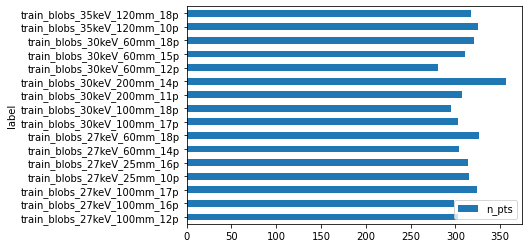

In [18]:
sample_hist = pd.DataFrame(columns = ["label", "n_pts"])
sample_hist["label"] = plot_labels
sample_hist = sample_hist.set_index("label")

for idx, sample_lab in enumerate(plot_labels):
    sample_hist.loc[sample_lab, "n_pts"] = np.size(np.where(sample_labels == idx))    
# sample_hist
sample_hist.plot.barh()

In [19]:
from pca_utils import *

In [20]:
dfN = get_latent_vector(encoder, x, sample_labels, plot_labels)
# savepath_latent = os.path.join(model_path, model_names["encoder"].split(".hdf5")[0] + ".csv")
# df16.to_csv(savepath_latent)
data_labels = plot_labels
dfN.columns

Index(['label_idx', '$h_0$', '$h_1$', '$h_2$', '$h_3$', '$h_4$', '$h_5$',
       '$h_6$', '$h_7$', '$h_8$', '$h_9$', '$h_10$', '$h_11$', '$h_12$',
       '$h_13$', '$h_14$', '$h_15$', '$h_16$', '$h_17$', '$h_18$', '$h_19$',
       '$h_20$', '$h_21$', '$h_22$', '$h_23$', '$h_24$', '$h_25$', '$h_26$',
       '$h_27$', '$h_28$', '$h_29$', '$h_30$', '$h_31$', 'label', 'shape',
       'param', 'measurement'],
      dtype='object')

In [21]:
ncomps = 2
pca, df = fit_PCA(dfN, hidden_units[-1], ncomps = ncomps, transform = True)
# plot_2Dprojection(df)

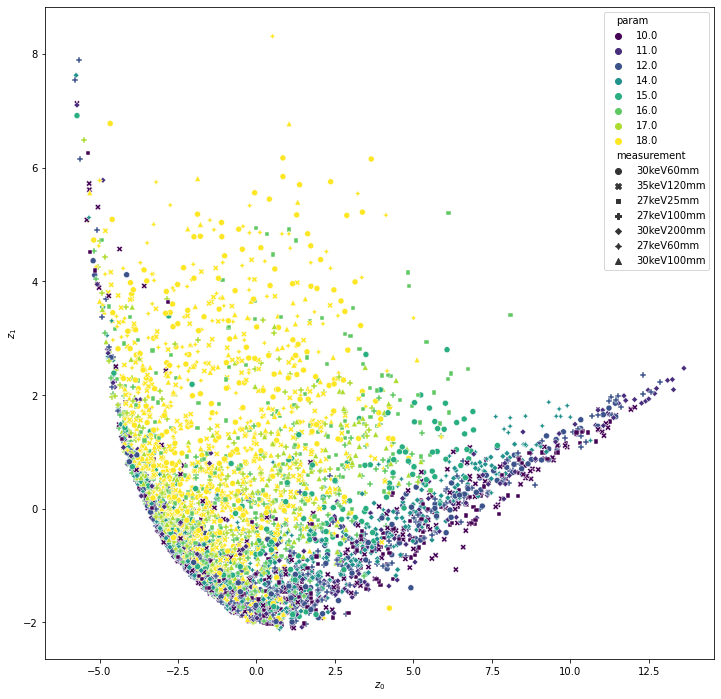

In [22]:
fig, ax = plt.subplots(1,1,figsize = (figw,figw))

sns.scatterplot(data = df, x = "$z_0$", y = "$z_1$", \
                hue = "param", \
                palette = "viridis", ax = ax, \
                legend = "full", \
                style = "measurement")
#                 size = "param", sizes = (50,100))
if ax is None:
    fig.tight_layout()


## Accuracy Metrics  

In [23]:
from ct_segnet.stats import calc_jac_acc
yp = segmenter.predict(x)
yp = np.round(yp)

Min IoU in datasets: 0.84


Text(0.5, 1.0, 'Patches')

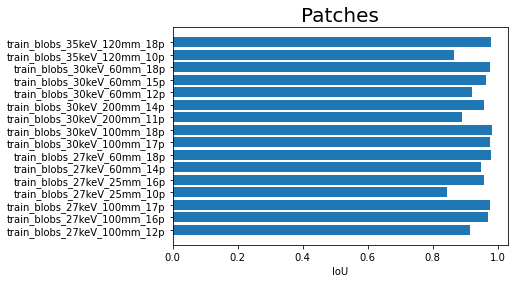

In [24]:
mean_IoUs = np.zeros(len(plot_labels))
for il, label in enumerate(plot_labels):
    mean_IoUs[il] = calc_jac_acc(y[sample_labels == il],\
                             yp[sample_labels == il])
plt.barh(plot_labels, mean_IoUs)
plt.xlabel("IoU")    
print("Min IoU in datasets: %.2f"%mean_IoUs.min())
plt.title("Patches", fontsize = 20)

In [25]:
mean_IoUs.shape

(16,)

## Save Model  

In [26]:
import pickle
# Save to file in the current working directory
pkl_filename = os.path.join(model_path, model_names["PCA"])
with open(pkl_filename, 'wb') as file:
    pickle.dump(pca, file)
    
segmenter.save(os.path.join(model_path, model_names["segmenter"]))
encoder.save(os.path.join(model_path, model_names["encoder"]))
print('trained : %s'%model_tag)

The end!

'110d32_set6'